# this is the 2nd notebook for the ASTR-19 Final Project

# installing sep and astropy
# basic imports

In [157]:
!pip install sep
!pip install astropy


import numpy as np
import sep

In [158]:
# additional setup for reading the test image and displaying plots
import astropy.io.fits
import matplotlib.pyplot as plt
from matplotlib import rcParams
from astropy.io import fits

%matplotlib inline

rcParams['figure.figsize'] = [10., 8.]

# Matplotlib parameters

# opening the UDF f105w image

In [159]:
with fits.open("../data/hlsp_hudf12_hst_wfc3ir_udfmain_f105w_v1.0_drz.fits") as hdul:
    data = hdul[0].data

# fixing byte order based on note in tutorial

In [165]:
# Ensure data is in native byte order
data = data.byteswap().newbyteorder()

# showing image & saving figure as png

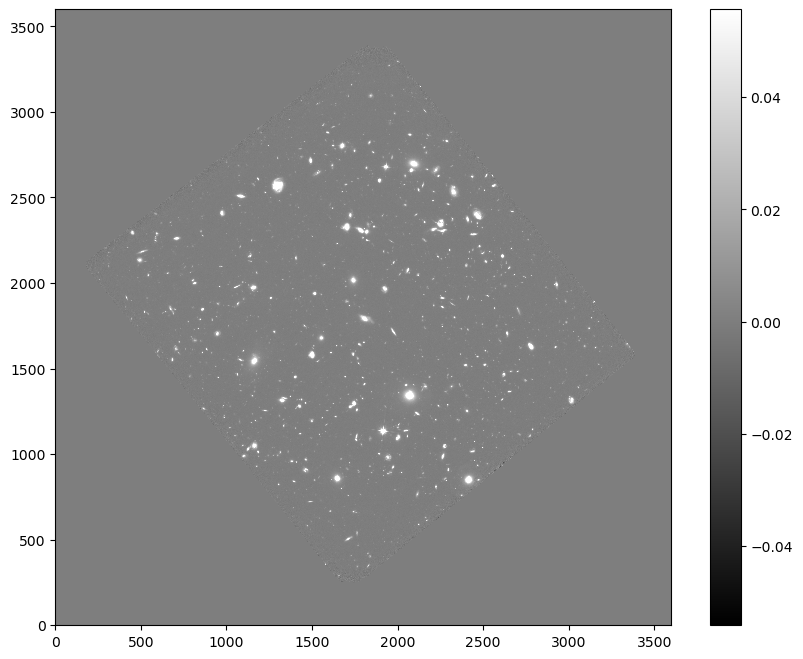

In [166]:
# show the image
m, s = np.mean(data), np.std(data)
plt.imshow(data, interpolation='nearest', cmap='gray', vmin=m-s, vmax=m+s, origin='lower')
plt.colorbar();
plt.savefig("image-f105-1.png")

In [167]:
# measure a spatially varying background on the image
bkg = sep.Background(data)

In [168]:
# get a "global" mean and noise of the image background:
print(bkg.globalback)
print(bkg.globalrms)

0.0
0.0005398219218477607


In [169]:
# evaluate background as 2-d array, same size as original image
bkg_image = bkg.back()

# evaluating the background

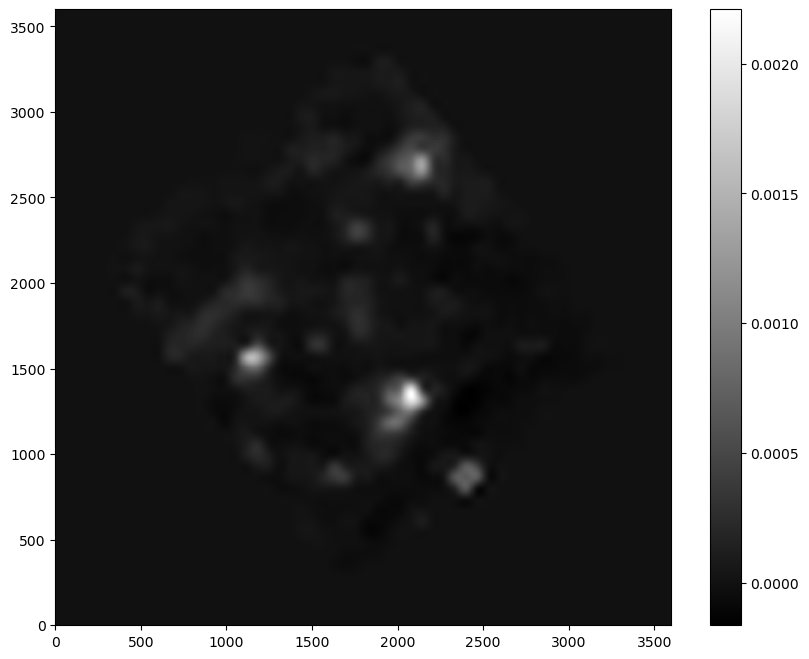

In [170]:
# show the background
plt.imshow(bkg_image, interpolation='nearest', cmap='gray', origin='lower')
plt.colorbar();
plt.savefig("image-f105-2.png")

In [171]:
# evaluate the background noise as 2-d array, same size as original image
bkg_rms = bkg.rms()

# showing the background noise

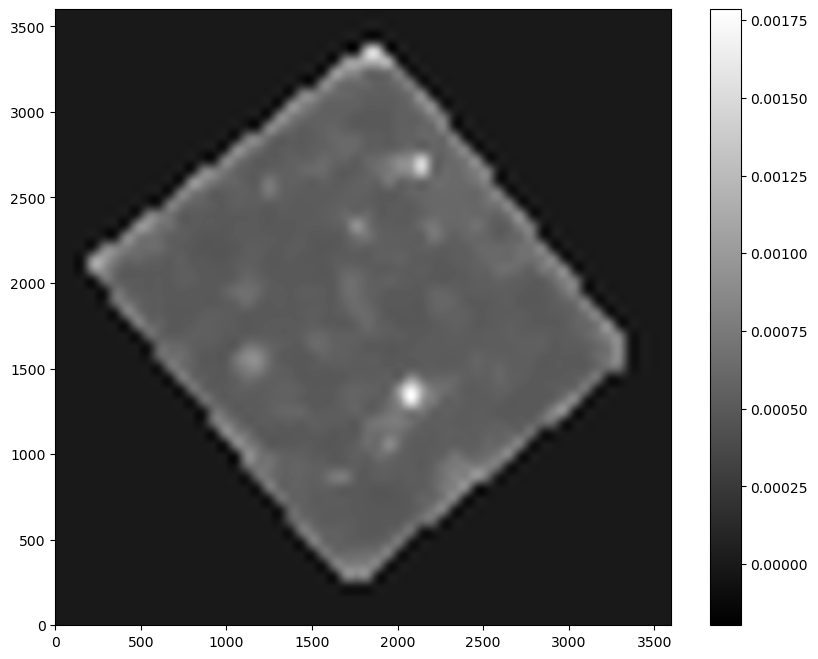

In [172]:
# show the background noise
plt.imshow(bkg_rms, interpolation='nearest', cmap='gray', origin='lower')
plt.colorbar();
plt.savefig("image-f105-3.png")

## subtracting the background

In [173]:
# subtract the background
data_sub = data - bkg

In [174]:
objects = sep.extract(data_sub, 1.5, err=bkg.globalrms)

# finding the number of souces (8646)

In [175]:
# how many objects were detected
len(objects)

8646

# showing the plot without background 
# saving it as png

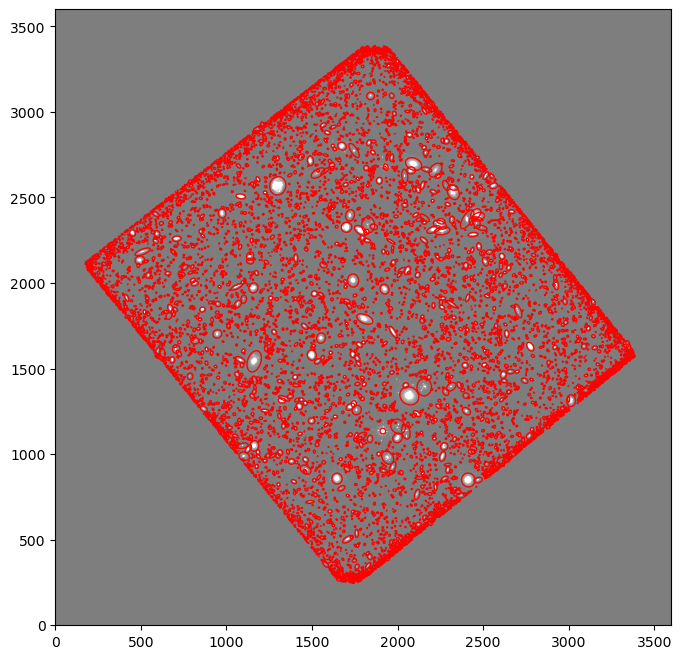

In [176]:
from matplotlib.patches import Ellipse

# plot background-subtracted image
fig, ax = plt.subplots()
m, s = np.mean(data_sub), np.std(data_sub)
im = ax.imshow(data_sub, interpolation='nearest', cmap='gray',
               vmin=m-s, vmax=m+s, origin='lower')

# plot an ellipse for each object
for i in range(len(objects)):
    e = Ellipse(xy=(objects['x'][i], objects['y'][i]),
                width=6*objects['a'][i],
                height=6*objects['b'][i],
                angle=objects['theta'][i] * 180. / np.pi)
    e.set_facecolor('none')
    e.set_edgecolor('red')
    ax.add_artist(e)
    
# save as png
plt.savefig("image-f105-4.png")

In [177]:
# available fields
objects.dtype.names

('thresh',
 'npix',
 'tnpix',
 'xmin',
 'xmax',
 'ymin',
 'ymax',
 'x',
 'y',
 'x2',
 'y2',
 'xy',
 'errx2',
 'erry2',
 'errxy',
 'a',
 'b',
 'theta',
 'cxx',
 'cyy',
 'cxy',
 'cflux',
 'flux',
 'cpeak',
 'peak',
 'xcpeak',
 'ycpeak',
 'xpeak',
 'ypeak',
 'flag')

# calculating the flux (light intensity) using sep.sum_circle function

In [178]:
flux, fluxerr, flag = sep.sum_circle(data_sub, objects['x'], objects['y'],
                                     3.0, err=bkg.globalrms, gain=1.0)

In [179]:
flux.shape

(8646,)

# calculating mean, median, and standard deviation of distribution of fluxes & finding the outlier (807)

In [180]:
mean_flux = np.mean(flux)
median_flux = np.median(flux)
std_flux = np.std(flux)

# finding the outlier
outliers = np.abs(flux - mean_flux)
max_outlier_index = np.argmax(outliers)
max_outlier_value = flux[max_outlier_index]
max_outlier_std_devs = outliers[max_outlier_index] / std_flux

# find location of the outlier on the image
outlier_x = objects['x'][max_outlier_index]
outlier_y = objects['y'][max_outlier_index]

# print the results
print(f"Mean Flux:{mean_flux}")
print(f"Median Flux:{median_flux}")
print(f"Standard Deviation Flux:{std_flux}")
print(f"Largest Outlier:{max_outlier_value}")
print(f"Outlier Location: (x={outlier_x}, y={outlier_y})")
print(f"Outlier Deviation from Mean: {max_outlier_std_devs} standard deviations")

Mean Flux:0.36159539075495284
Median Flux:0.03097589430617518
Standard Deviation Flux:9.24028235192194
Largest Outlier:807.2972835731507
Outlier Location: (x=1914.2549094883857, y=1134.3164850742164)
Outlier Deviation from Mean: 87.32803365197564 standard deviations


In [181]:
# show the first 10 objects results:
for i in range(10):
    print("object {:d}: flux = {:f} +/- {:f}".format(i, flux[i], fluxerr[i]))

object 0: flux = 0.031282 +/- 0.176890
object 1: flux = 0.031018 +/- 0.176142
object 2: flux = -0.024388 +/- 0.002883
object 3: flux = 0.001947 +/- 0.044219
object 4: flux = 0.012457 +/- 0.111649
object 5: flux = -0.011228 +/- 0.002875
object 6: flux = 0.029368 +/- 0.171394
object 7: flux = -0.009126 +/- 0.002875
object 8: flux = 0.048023 +/- 0.219161
object 9: flux = 0.027840 +/- 0.166877


# plotting a histogram of the fluxes

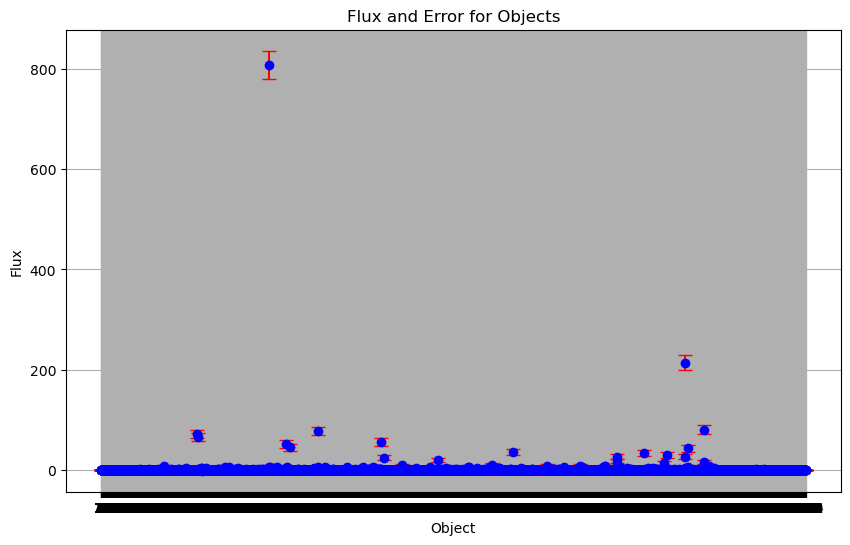

In [182]:
import matplotlib.pyplot as plt

# Number of objects to plot
n_objects = 8646

# Object IDs (0 to n_objects-1)
objects = list(range(n_objects))

# Plotting
plt.figure(figsize=(10, 6))
plt.errorbar(objects, flux[:n_objects], yerr=fluxerr[:n_objects], fmt='o', ecolor='red', capsize=5, color='blue')
plt.xlabel('Object')
plt.ylabel('Flux')
plt.title('Flux and Error for Objects')
plt.xticks(objects)
plt.grid(True)

# Show the plot
plt.show()


# make a 3-color false image of the UDF using RGB -> f160w, f125w, f125w, f105w

In [183]:
# define file names 
fdata_F160W = "hlsp_hudf12_hst_wfc3ir_udfmain_f160w_v1.0_drz.fits"
fdata_F125W = "hlsp_hudf12_hst_wfc3ir_udfmain_f125w_v1.0_drz.fits"
fdata_F105W = "hlsp_hudf12_hst_wfc3ir_udfmain_f105w_v1.0_drz.fits"

# read in data
hdu_2 = fits.open(fdata_F160W)
hdu_3 = fits.open(fdata_F125W)
hdu_4 = fits.open(fdata_F105W)

# get the image data 
data_2 = hdu_2[0].data
data_3 = hdu_3[0].data
data_4 = hdu_4[0].data

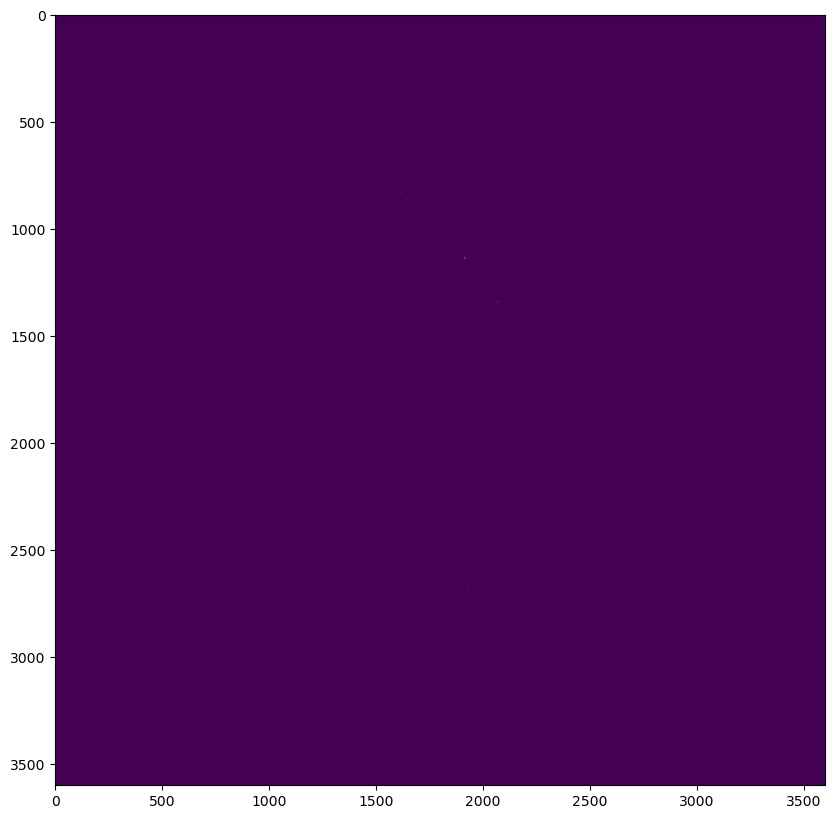

In [184]:
# visualize data unscaled
f = plt.figure(figsize=(10,10))
plt.imshow(data_2)

In [185]:
# rescale data to see faint objects
def rescale_image(data):
    pdata_tmp = data.copy()
    m = np.nanmean(pdata_tmp)
    vplmin = m/2.
    vpmin = np.log10(vplmin)
    vpmax = np.log10(m * 100.)
    pdata_tmp[pdata_tmp<vplmin] = vplmin
    pdata_tmp = np.log10(pdata_tmp)
    return pdata_tmp,vpmin,vpmax

In [186]:
# plot rescaled data
def fits_quicklook(data,fnx=10,fny=10):
    f = plt.figure(figsize=(fnx,fny))
    pdata_tmp,vpmin,vpmax = rescale_image(data)
    plt.imshow(pdata_tmp,vmin=vpmin, vmax=vpmax)

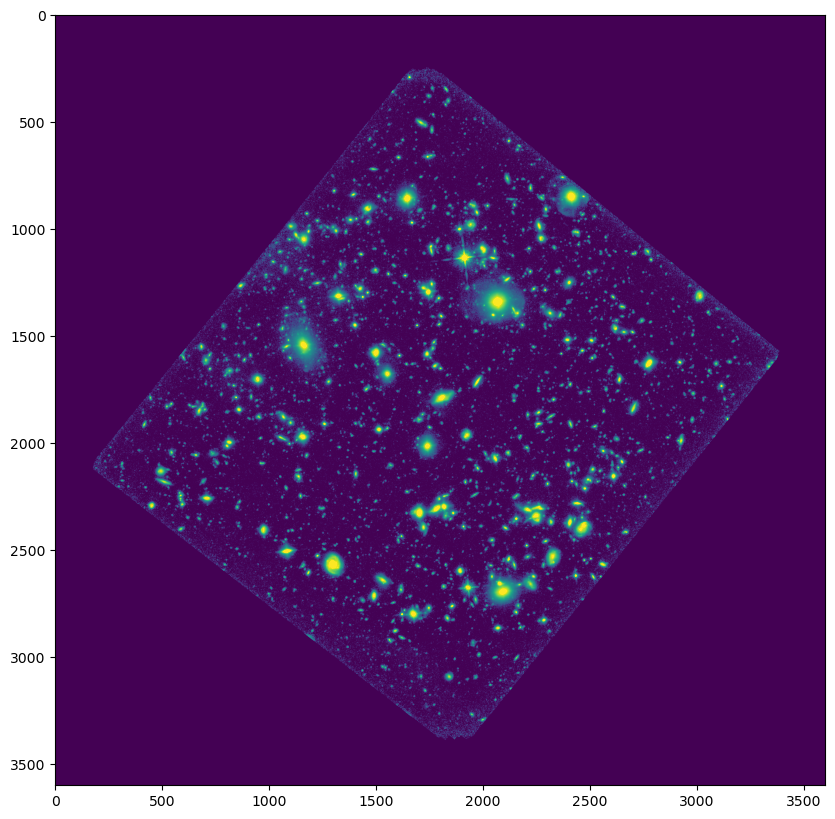

In [187]:
# show image
fits_quicklook(data_2)

In [188]:
# use these rescaled images 
data_2_res, d2min, d2max = rescale_image(data_2)
data_3_res, d3min, d3max = rescale_image(data_3)
data_4_res, d4min, d4max = rescale_image(data_4)

# limit data to be between min and max values in rescaling

In [189]:
data_2_res[data_2_res<d2min] = d2min
data_2_res[data_2_res>d2max] = d2max
data_3_res[data_3_res<d3min] = d3min
data_3_res[data_3_res>d3max] = d3max
data_4_res[data_4_res<d4min] = d4min
data_4_res[data_4_res>d4max] = d4max

# create an RGB image

In [152]:
rgb = np.zeros((data_2_res.shape[0], data_2_res.shape[1],3))
rgb[:,:,0] = (data_2_res-d2min)/(d2max-d2min)
rgb[:,:,1] = (data_3_res-d3min)/(d3max-d3min)
rgb[:,:,2] = (data_4_res-d4min)/(d4max-d4min)

# plot RGB image and save to a PNG

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


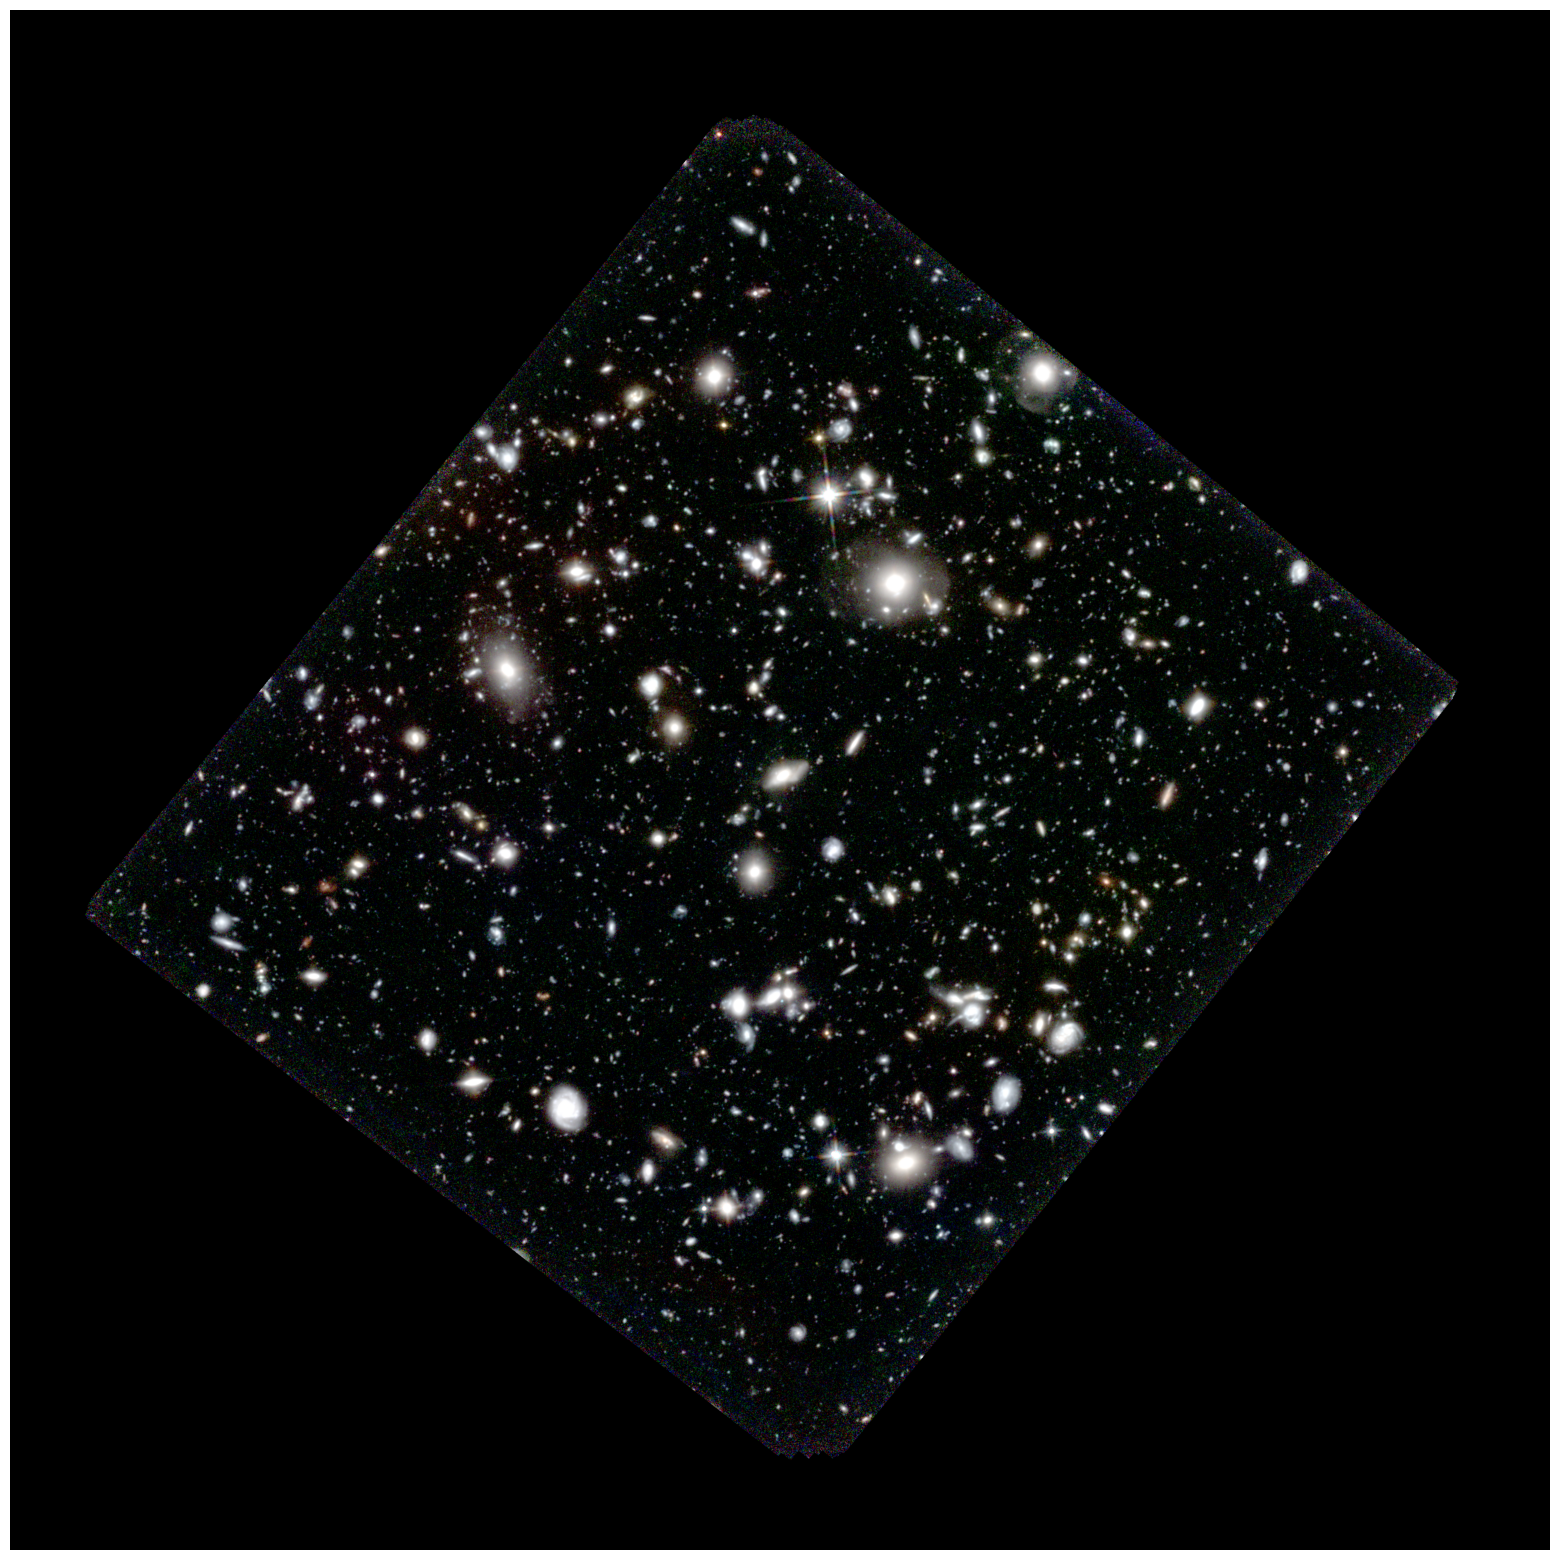

In [153]:
f,ax = plt.subplots(1,1,figsize=(20,20))
ax.axis('off')
ax.imshow(rgb)
plt.savefig('sep_rgb_image.png',bbox_inches='tight',pad_inches=0,dpi=600)